<a href="https://colab.research.google.com/github/muhafidz-ahmad/simple-android-app-fruits-classification/blob/main/analisis_data_dan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Khayalan Pemisahan Buah Segar dan Busuk

## Rumusan Masalah

* Banyaknya buah-buahan yang masuk ke toko menjadikan pekerja harus lebih bekerja keras untuk memisahkan tiap buahnya serta memisahkan antara buah yang masih segar dan buah yang telah busuk. 

* Machine learning diharapkan dapat membantu untuk memisahkan buah-buahan tersebut sehingga dapat disimpan pada tempatnya.

<p align="center">
  <img src="https://www.eitfood.eu/files/_1200x590_crop_center-center_none/fruits.jpg" alt="Buah-buahan" width="500">
</p>

Data akan diambil dari [kaggle](https://www.kaggle.com/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables?select=ImageLabels.txt).

Data terdiri dari beberapa jenis gambar buah-buahan yang segar dan juga yang busuk. Tiap gambar telah dipisahkan dalam foldernya masing-masing sesuai dengan jenis buah dan kesegarannya.

## Persiapan Package

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import splitfolders
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Impor data dari kaggle

Upload file kaggle.json agar bisa impor data dari kaggle secara langsung ke google colab

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhafidzahmadhalim","key":"3af9a2f54c0c3c2fbd6c4837892e7e3f"}'}

Memindahkan file kaggle.json ke folder /root/.kaggle/

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


Unduh data dari kaggle dan ekstrak datanya yang masih memiliki format zip

In [ ]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables
!mkdir /content/data
!unzip /content/fresh-and-stale-images-of-fruits-and-vegetables.zip -d /content/data

os.remove('/content/data/ImageLabels.txt')

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.09 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.15 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.24 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.32 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.38 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.21 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.27 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.33 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.40 PM.png  
  inflating: /content/data/stale_banana/rotated_by_15_Screen Shot 20

## Exploratory Data Analysis

### Preview data gambar

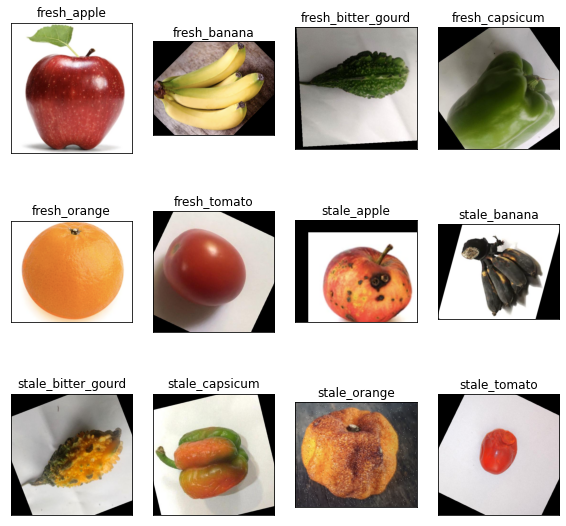

In [ ]:
class_name = list(os.listdir('/content/data'))
class_name.sort()

seed = 53

fig, ax = plt.subplots(3, 4, figsize = (8, 8))
for num, image in enumerate(class_name):
  row = int(num/4)
  col = num % 4
  img = mpimg.imread('/content/data/%s/'%image 
                     + os.listdir('/content/data/' + image)[seed])
  ax[row,col].imshow(img)
  ax[row,col].set_title(image)
  ax[row,col].set_xticks([])
  ax[row,col].set_yticks([])

fig.tight_layout()

Berdasarkan beberapa contoh gambar yang telah ditampilkan di atas, terlihat bahwa semua buah-buahan tersimpan di atas alas atau latar dengan warna yang cukup polos.

### Visualisasi jumlah gambar tiap kelas

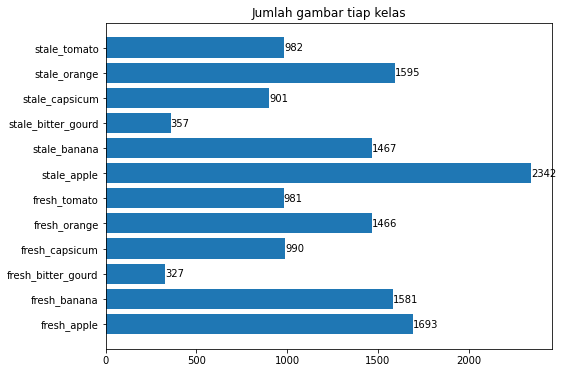

In [ ]:
count_class = [len(os.listdir('/content/data/' + c)) for c in class_name]

df_class = pd.DataFrame({'kelas': class_name,
                         'jumlah': count_class})

plt.figure(figsize = (8,6))
plt.barh(df_class['kelas'], df_class['jumlah'])
plt.title('Jumlah gambar tiap kelas')

for index, value in enumerate(df_class['jumlah']):
    plt.text(value, index, str(value),
             position = (value, index-0.13))

Dari visualisasi di atas, dapat dikatakan data tidak seimbang karena jumlah tiap kelas memiliki perbedaan yang cukup jauh. Namun tetap akan dilakukan percobaan pelatihan model machine learning klasifikasi menggunakan data ini. Jika performa model buruk, maka akan dilakukan pemrosesan data lebih lanjut.

### Visualisasi jumlah gambar buah yang segar dan busuk

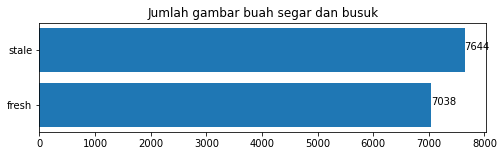

In [ ]:
df_fresh_stale = pd.DataFrame({'fresh': [sum(count_class[:int(len(count_class)/2)])],
                               'stale': [sum(count_class[int(len(count_class)/2):])]})

plt.figure(figsize = (8,2))
plt.barh(df_fresh_stale.columns, df_fresh_stale.iloc[0])
plt.title('Jumlah gambar buah segar dan busuk')

for index, value in enumerate(df_fresh_stale.iloc[0]):
    plt.text(value, index, str(value),
             position = (value, index))

### Visualisasi jumlah gambar buah

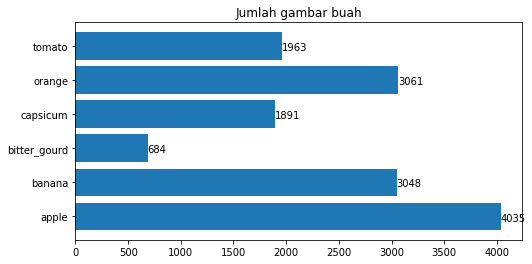

In [ ]:
fruits_name = ('apple', 'banana', 'bitter_gourd', 
               'capsicum', 'orange', 'tomato')
fruits_count = [0 for i in range(len(fruits_name))]

for nomor, fruit in enumerate(fruits_name):
  for kelas in os.listdir('/content/data'):
    if kelas[6:] == fruit:
      fruits_count[nomor] += len(os.listdir('/content/data/'+kelas))

plt.figure(figsize = (8,4))
plt.barh(fruits_name, fruits_count)
plt.title('Jumlah gambar buah')

for index, value in enumerate(fruits_count):
    plt.text(value, index, str(value),
             position = (value, index-0.13))

Data yang tidak seimbang ini disebabkan oleh jumlah data gambar buah yang jauh perbedaannya. 

## Pemisahan Data Latih dan Data Validasi

In [ ]:
base_dir = '/content/data_split/'

splitfolders.ratio('/content/data/', output = '/content/data_split',
                   seed = 45, ratio = (0.8, 0.2))

train_dir = base_dir + 'train/'
val_dir = base_dir + 'val/'

Copying files: 14682 files [00:05, 2470.28 files/s]


## Augmentasi Gambar

Dilakukan augmentasi gambar untuk melakukan transformasi pada gambar data latih sehingga akan membuat variasi yang lebih banyak pada data latih. Hal ini dilakukan untuk mengurangi overfitting ketika proses pelatihan.

Augmentasi yang dilakukan adalah:
1. Rescale nilai vektor gambar menjadi antara 0 hingga 1.
2. Memutar atau merotasi gambar hingga 20 derajat.
3. Membalikkan gambar secara horizontal maupun vertikal.
4. Mengisi bagian gambar yang kosong dengan warna yang ada didekatnya.

In [ ]:
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = 9,
    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = 9,
    class_mode = 'categorical')

Found 11739 images belonging to 12 classes.
Found 2943 images belonging to 12 classes.


Di bawah ini adalah contoh gambar hasil augmentasi gambar data latih.

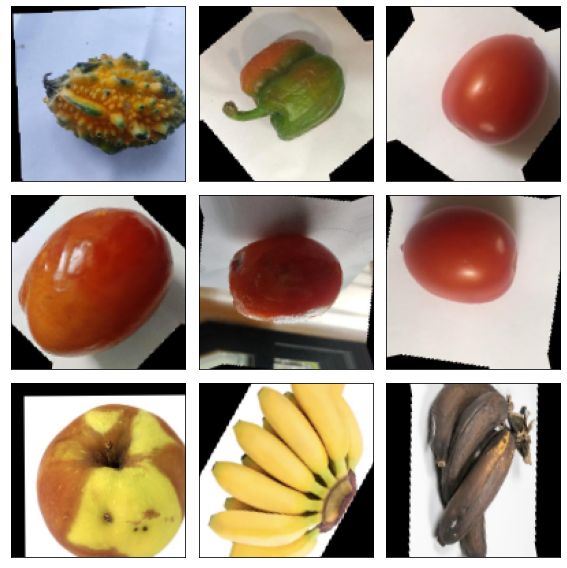

In [ ]:
id_batch = 453

fig, ax = plt.subplots(3, 3, figsize = (8, 8))
for num, image in enumerate(train_generator[id_batch][0]):
    row = int(num/3)
    col = num % 3
    ax[row,col].imshow(image)
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])

fig.tight_layout()

## Pembuatan Model Machine Learning

Model machine learning akan dibuat menggunakan Convolutional Neural Networks dengan lapisan sebagai berikut.

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.95:
            print("\nThe accuracy has reached > 0.95!")
            self.model.stop_training = True
            
callbacks = myCallback()

def create_model(lr = 0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3),
                                  activation = 'relu',
                                  input_shape = (img_height, img_width, 3)))
    model.add(keras.layers.MaxPooling2D(3,3))
    model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(4,4))
    model.add(keras.layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(3,3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = 'relu'))
    model.add(keras.layers.Dense(32, activation = 'relu'))
    model.add(keras.layers.Dense(12, activation = 'softmax'))
    
    adam = keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics = ['acc'])
    
    return model

model = create_model(lr = 0.0008)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

Model akan dilatih dengan jumlah epochs sebanyak 45 dengan batch size 128. Optimizer yang digunakan adalah adam optimizer dengan nilai learning rate 0,0008.

In [ ]:
hist = model.fit(train_generator,
                 epochs = 45,
                 steps_per_epoch = 100,
                 batch_size = 128,
                 validation_data = val_generator,
                 verbose = 1,
                 callbacks = [callbacks])

Epoch 1/45
100/100 [==============================] - 19s 178ms/step - loss: 2.3573 - acc: 0.1711 - val_loss: 2.1741 - val_acc: 0.2871
Epoch 2/45
100/100 [==============================] - 17s 174ms/step - loss: 2.0198 - acc: 0.2767 - val_loss: 1.7197 - val_acc: 0.4118
Epoch 3/45
100/100 [==============================] - 19s 192ms/step - loss: 1.5132 - acc: 0.4744 - val_loss: 1.3159 - val_acc: 0.5093
Epoch 4/45
100/100 [==============================] - 20s 201ms/step - loss: 1.1908 - acc: 0.5656 - val_loss: 1.0077 - val_acc: 0.6602
Epoch 5/45
100/100 [==============================] - 22s 223ms/step - loss: 0.9879 - acc: 0.6411 - val_loss: 0.8794 - val_acc: 0.6945
Epoch 6/45
100/100 [==============================] - 17s 172ms/step - loss: 0.8117 - acc: 0.7011 - val_loss: 0.7634 - val_acc: 0.7370
Epoch 7/45
100/100 [==============================] - 17s 173ms/step - loss: 0.8134 - acc: 0.7200 - val_loss: 0.8552 - val_acc: 0.6694
Epoch 8/45
100/100 [==============================] - 1

## Plot evaluasi hasil pelatihan

<function matplotlib.pyplot.show(*args, **kw)>

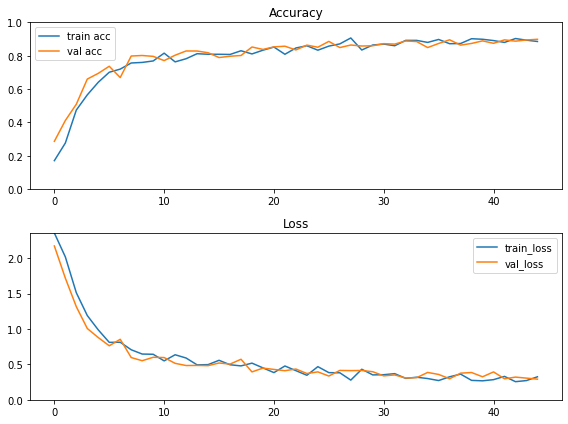

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (8,6))

ax[0].plot(hist.history['acc'], label = 'train acc')
ax[0].plot(hist.history['val_acc'], label = 'val acc')
ax[0].legend()
ax[0].set_title('Accuracy')
ax[0].set_ylim(0, 1)

ax[1].plot(hist.history['loss'], label = 'train_loss')
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_ylim([0,max(hist.history['loss'] + hist.history['val_loss'])])

fig.tight_layout()
plt.show

Dari grafik di atas, terlihat model tidak mengalami overfitting dan mendapatkan akurasi yang tinggi meskipun data terbilang tidak seimbang.

Diperoleh akurasi pada data latih di epoch terakhir adalah 88,56%, dan akurasi pada data validasi di epoch terakhir adalah 89,87%.
Ini artinya model sudah memiliki performa yang baik.

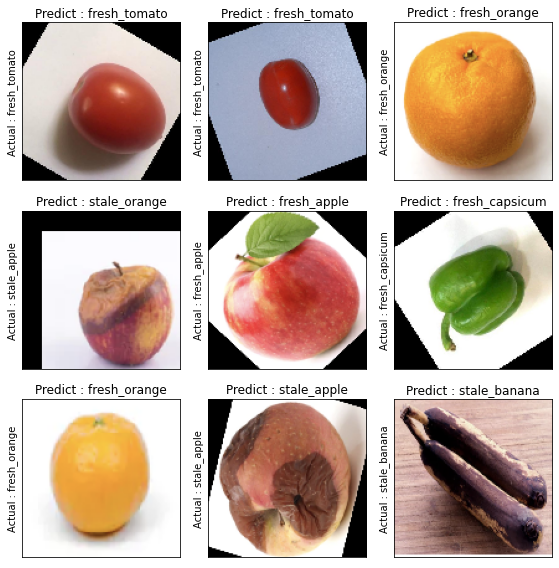

In [ ]:
labels = os.listdir('/content/data_split/train/')
labels.sort()

id_batch = 45

fig, ax = plt.subplots(3, 3, figsize = (8, 8))
for num, image in enumerate(val_generator[id_batch][0]):
    actual = 'Actual : ' + labels[np.where(val_generator[id_batch][1][num] == 1)[0][0]]
    
    image = np.expand_dims(image, axis=0)
    
    predict = model.predict(image, verbose=0)
    predict = 'Predict : ' + labels[np.argmax(predict)]
    
    row = int(num/3)
    col = num % 3
    ax[row,col].imshow(image[0])
    ax[row,col].set_title(predict)
    ax[row,col].set_ylabel(actual)
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])
    #ax[row,col].axis("off")

fig.tight_layout()

Terlihat terdapat salah satu gambar yang salah diprediksi (kiri tengah). Terjadi kesalahan pada prediksi jenis buah yang seharusnya apel namun model memprediksinya sebagai jeruk. Sedangkan untuk tingkat kesegarannya, model memprediksinya dengan benar, yaitu buah tersebut sudah busuk.

## Simpan model dalam TF-Lite

Karena performa model sudah baik dengan akurasi validasi di 89%, selanjutnya model akan disimpan dalam format TF-Lite untuk dilakukan deployment pada aplikasi android/ios.

In [ ]:
export_dir = '/content/saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('fresh_fruits.tflite')
tflite_model_file.write_bytes(tflite_model)

619560